# !wandb login

In [2]:
import json
import wandb
import numpy as np
import pandas as pd
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/schnet_qm9E(-q)_replica",
    # {"$or": [{"group": "PdZnFeCu_T100K_single_config_v1"}]},
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

Found 560 runs


In [3]:
potential_parameter = runs[0].config["potential_parameter"]

In [4]:
potential_parameter

"potential_name='SchNet' only_unique_pairs=False core_parameter=CoreParameter(number_of_radial_basis_functions=64, maximum_interaction_radius=0.49999999999999994, number_of_interaction_modules=12, number_of_filters=256, shared_interactions=True, activation_function_parameter=ActivationFunctionConfig(activation_function_name='ShiftedSoftplus', activation_function_arguments=None, activation_function=ShiftedSoftplus()), featurization=Featurization(properties_to_featurize=['atomic_number'], atomic_number=AtomicNumber(maximum_atomic_number=101, number_of_per_atom_features=1024), atomic_period=AtomicPeriod(maximum_period=8, number_of_per_period_features=32), atomic_group=AtomicGroup(maximum_group=18, number_of_per_group_features=32)), predicted_properties=['per_atom_energy'], predicted_dim=[1]) postprocessing_parameter=PostProcessingParameter(properties_to_process=['per_atom_energy'], per_atom_energy=PerAtomEnergy(normalize=False, from_atom_to_system_reduction=True, keep_per_atom_property=Tr

In [5]:
training_parameter = runs[0].config["training_parameter"]

In [6]:
training_parameter

"monitor='val/per_system_energy/rmse' number_of_epochs=500 remove_self_energies=True shift_center_of_mass_to_origin=False batch_size=128 lr=0.0005 plot_frequency=1 lr_scheduler=ReduceLROnPlateauConfig(scheduler_name='ReduceLROnPlateau', frequency=1, interval='epoch', monitor='val/per_system_energy/rmse', mode='min', factor=0.5, patience=10, threshold=0.1, threshold_mode='abs', cooldown=15, min_lr=1e-06, eps=1e-08) loss_parameter=LossParameter(loss_components=['per_atom_energy'], weight={'per_atom_energy': 1.0}, target_weight={'per_atom_energy': 1.0}, mixing_steps={'per_atom_energy': 1.0}) early_stopping=EarlyStopping(verbose=True, monitor='val/per_system_energy/rmse', min_delta=0.1, patience=100) splitting_strategy=SplittingStrategy(name='random_record_splitting_strategy', data_split=[0.8, 0.1, 0.1], seed=46) stochastic_weight_averaging=None experiment_logger=ExperimentLogger(logger_name='wandb', tensorboard_configuration=None, wandb_configuration=WandbConfig(save_dir='logs', project='

In [194]:
runs[0].summary

{'test/per_system_energy/mae': 1.6198532581329346, 'test/per_system_energy/rmse': 4.439447402954102, '_runtime': 17455.951912647, '_step': 2338, '_timestamp': 1743467955.1781373, '_wandb': {'runtime': 17456}, 'epoch': 333, 'epoch_time': 51.85737228393555, 'loss/per_atom_energy/mse': 0.05196163058280945, 'loss/per_atom_energy/weight': 1, 'loss/total_loss/mse': 0.05196163058280945, 'lr': 9.999999974752427e-07, 'outlier_count/test/100229': 1, 'outlier_count/test/122104': 1, 'outlier_count/test/64951': 1, 'outlier_count/val/10118': 2, 'outlier_count/val/101761': 1, 'outlier_count/val/106636': 19, 'outlier_count/val/114267': 319, 'outlier_count/val/119520': 1, 'outlier_count/val/125485': 3, 'outlier_count/val/131146': 1, 'outlier_count/val/13516': 1, 'outlier_count/val/15072': 1, 'outlier_count/val/15949': 1, 'outlier_count/val/2310': 5, 'outlier_count/val/23139': 1, 'outlier_count/val/28228': 1, 'outlier_count/val/30092': 1, 'outlier_count/val/38005': 1, 'outlier_count/val/4057': 1, 'outli

In [195]:
runs[0].config

{'potential_seed': None,
 'optimizer_class': 'AdamW',
 'dataset_statistic': {'atomic_self_energies': {'C': '-99366.70745535441 kilojoule_per_mole',
   'F': '-261811.54555874597 kilojoule_per_mole',
   'H': '-1313.4668615546 kilojoule_per_mole',
   'N': '-143309.9379722722 kilojoule_per_mole',
   'O': '-197082.0671774158 kilojoule_per_mole'},
  'training_dataset_statistics': {'per_atom_energy_mean': '-409.48571973637587 kilojoule_per_mole',
   'per_atom_energy_stddev': '18.292824647215742 kilojoule_per_mole'}},
 'training_parameter': "monitor='val/per_system_energy/rmse' number_of_epochs=500 remove_self_energies=True shift_center_of_mass_to_origin=False batch_size=128 lr=0.0005 plot_frequency=1 lr_scheduler=ReduceLROnPlateauConfig(scheduler_name='ReduceLROnPlateau', frequency=1, interval='epoch', monitor='val/per_system_energy/rmse', mode='min', factor=0.5, patience=10, threshold=0.1, threshold_mode='abs', cooldown=15, min_lr=1e-06, eps=1e-08) loss_parameter=LossParameter(loss_component

In [7]:
def extract_config(config_str, key):
    import re
    key_match = re.search(r'\b'+key+r'\b', config_str)

    if not key_match:
        raise KeyError("No such key in the config string!")
    key_begin_idx = key_match.start()

    key_end_idx = config_str.find(' ', key_begin_idx)
    extracted_string = config_str[key_begin_idx : key_end_idx]

    count = 0
    while count < 1000:
        count += 1

        # match parentheses 
        if extracted_string.count(']') - extracted_string.count('[') < 0 or extracted_string.count(')') - extracted_string.count('(') < 0:
            key_end_idx = config_str.find(' ', key_end_idx + 1)
            extracted_string = config_str[key_begin_idx : key_end_idx]

        # get rid of the last ','
        elif extracted_string[-1] == ',':
            extracted_string = extracted_string[:-1]

        # extract dict from the extracted string
        else:
            values = extracted_string[len(key) + 1 : ]
            tail_length = values.count(']') - values.count('[') + values.count(')') - values.count('(')
            values = values[:len(values) - tail_length]

            # convert to dict
            try:
                values = int(values)
            except ValueError:
                try:
                    values = float(values)
                except ValueError:
                    pass
            result = {key: values}
            return result

In [8]:
extract_config(potential_parameter, "number_of_per_atom_features")

{'number_of_per_atom_features': 1024}

In [9]:
extract_config(potential_parameter, "number_of_filters")

{'number_of_filters': 256}

In [10]:
extract_config(potential_parameter, "number_of_interaction_modules")

{'number_of_interaction_modules': 12}

In [11]:
runs[0].summary["test/per_system_energy/mae"]

1.6198532581329346

In [12]:
extract_config(extract_config(training_parameter, "splitting_strategy")["splitting_strategy"], "seed")

{'seed': 46}

In [13]:
test_results = []

for run in runs:
    record = {}

    record.update({"name": run.name})

    potential_parameter = run.config["potential_parameter"]
    record.update(extract_config(potential_parameter, "number_of_per_atom_features"))
    record.update(extract_config(potential_parameter, "number_of_filters"))
    record.update(extract_config(potential_parameter, "number_of_interaction_modules"))

    record.update({
        "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
        "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
    })

    training_parameter = run.config["training_parameter"]
    record.update(
        extract_config(extract_config(training_parameter, "splitting_strategy")["splitting_strategy"], "seed")
    )

    test_results.append(record)

test_results = pd.DataFrame(test_results)

In [25]:
test_results.sort_values(by="test/per_system_energy/rmse")

,name,number_of_per_atom_features,number_of_filters,number_of_interaction_modules,test/per_system_energy/mae,test/per_system_energy/rmse,seed
196,3_256_1024(45),1024,256,3,1.527891,2.806468,45
281,6_256_512(44),512,256,6,1.555241,2.835932,44
113,12_256_512(45),512,256,12,1.516618,3.000800,45
112,12_256_1024(45),1024,256,12,1.509539,3.085273,45
225,12_256_1024(44),1024,256,12,1.635997,3.134676,44
...,...,...,...,...,...,...,...
425,3_256_64(43),64,256,3,3.682238,57.594643,43
384,9_64_16(43),16,64,9,8.655968,157.097107,43
397,6_256_32(43),32,256,6,7.258186,459.094055,43
375,9_128_16(43),16,128,9,9.929444,523.791016,43


In [28]:
# seed 43 causing large error outliers, ignore for now

filtered_results = test_results[test_results["seed"] != 43]

<Axes: xlabel='number_of_interaction_modules', ylabel='test/per_system_energy/rmse'>

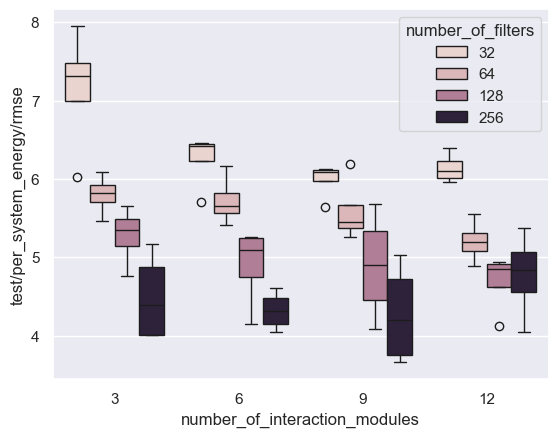

In [45]:
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

filtered_results = filtered_results[filtered_results["number_of_per_atom_features"] == 128]

sns.boxplot(
    data=filtered_results,
    x="number_of_interaction_modules",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
    # whis=(0, 100),
)

<Axes: xlabel='number_of_interaction_modules', ylabel='test/per_system_energy/rmse'>

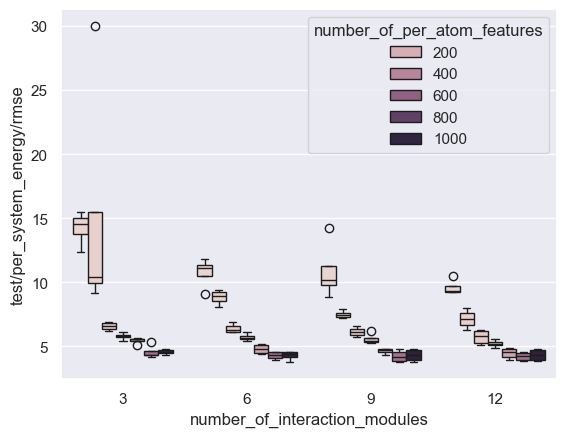

In [36]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

filtered_results = filtered_results[filtered_results["number_of_filters"] == 64]

sns.boxplot(
    data=filtered_results,
    x="number_of_interaction_modules",
    y="test/per_system_energy/rmse",
    hue="number_of_per_atom_features",
    # whis=(0, 100),
)

<Axes: xlabel='number_of_per_atom_features', ylabel='test/per_system_energy/rmse'>

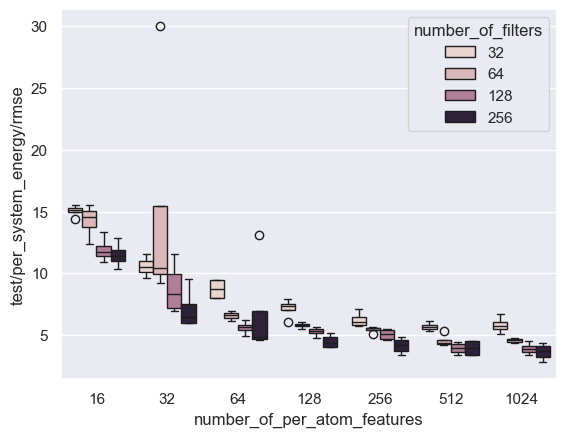

In [37]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

filtered_results = filtered_results[filtered_results["number_of_interaction_modules"] == 3]

sns.boxplot(
    data=filtered_results,
    x="number_of_per_atom_features",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
    # whis=(0, 100),
)

<Axes: xlabel='number_of_per_atom_features', ylabel='test/per_system_energy/rmse'>

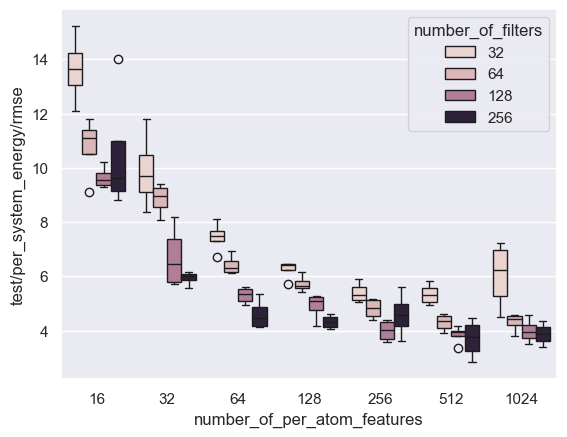

In [38]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

filtered_results = filtered_results[filtered_results["number_of_interaction_modules"] == 6]

sns.boxplot(
    data=filtered_results,
    x="number_of_per_atom_features",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
    # whis=(0, 100),
)

<Axes: xlabel='number_of_per_atom_features', ylabel='test/per_system_energy/rmse'>

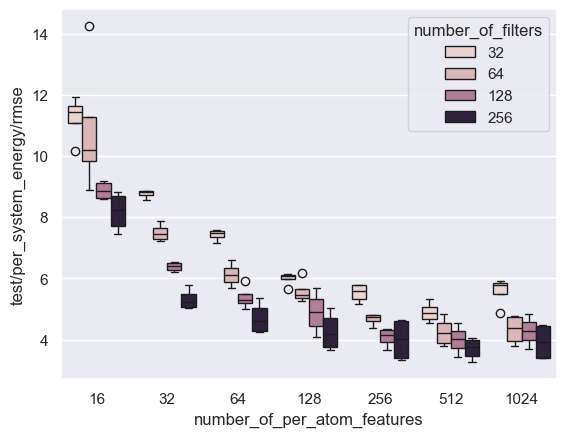

In [39]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

filtered_results = filtered_results[filtered_results["number_of_interaction_modules"] == 9]

sns.boxplot(
    data=filtered_results,
    x="number_of_per_atom_features",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
    # whis=(0, 100),
)

<Axes: xlabel='number_of_per_atom_features', ylabel='test/per_system_energy/rmse'>

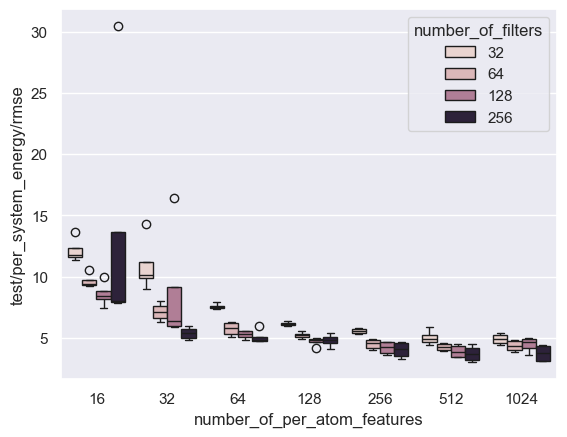

In [40]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

filtered_results = filtered_results[filtered_results["number_of_interaction_modules"] == 12]
# filtered_results = filtered_results[filtered_results["number_of_filters"] == 64]

sns.boxplot(
    data=filtered_results,
    x="number_of_per_atom_features",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
    # whis=(0, 100),
)

<Axes: xlabel='number_of_per_atom_features', ylabel='test/per_system_energy/rmse'>

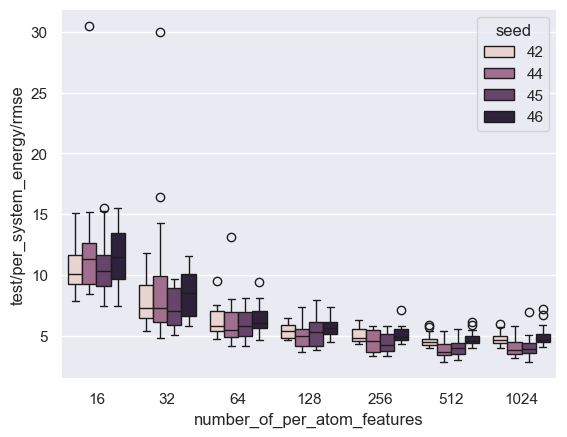

In [41]:
filtered_results = test_results
# filtered_results = filtered_results[filtered_results["number_of_per_atom_features"] != 16]
# filtered_results = filtered_results[filtered_results["number_of_per_atom_features"] != 32]
# filtered_results = filtered_results[test_results["number_of_per_atom_features"] != 64]

filtered_results = filtered_results[filtered_results["seed"] != 43]

sns.boxplot(
    data=filtered_results,
    x="number_of_per_atom_features",
    y="test/per_system_energy/rmse",
    hue="seed",
    # whis=(0, 100),
)

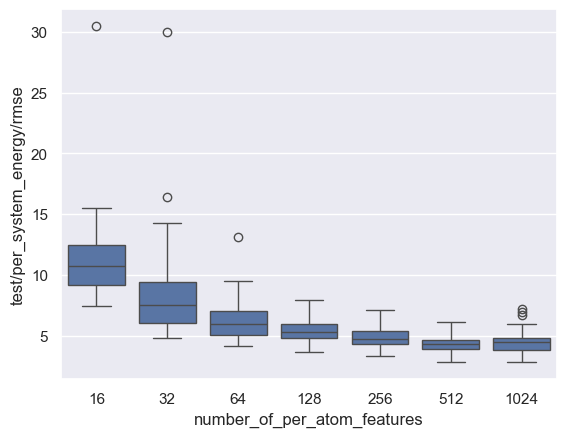

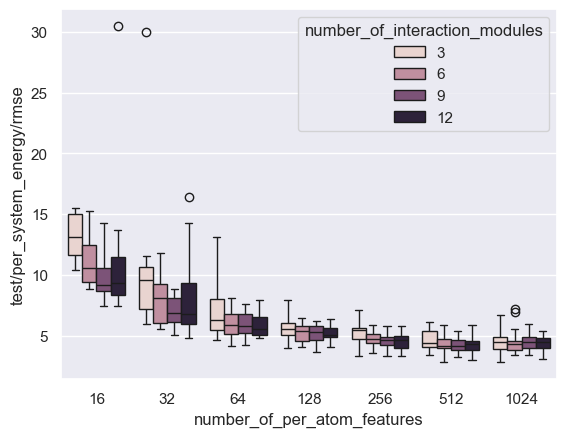

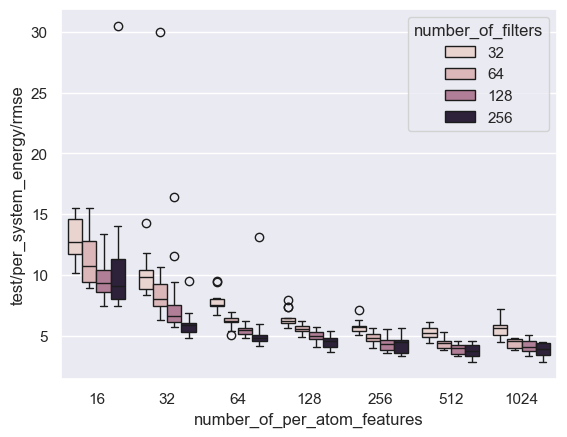

In [164]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]
for i in [None, "number_of_interaction_modules", "number_of_filters"]:
    sns.boxplot(
        data=filtered_results,
        x="number_of_per_atom_features",
        y="test/per_system_energy/rmse",
        hue=i,
        whis=2,
    )
    plt.show()

In [156]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

filtered_results[filtered_results["number_of_per_atom_features"] == 16]["test/per_system_energy/rmse"].std()

3.343250820094806

In [157]:
filtered_results[filtered_results["number_of_per_atom_features"] == 32]["test/per_system_energy/rmse"].std()

3.578014419326723

In [158]:
filtered_results[filtered_results["number_of_per_atom_features"] == 64]["test/per_system_energy/rmse"].std()

1.5268903142454409

In [159]:
filtered_results[filtered_results["number_of_per_atom_features"] == 128]["test/per_system_energy/rmse"].std()

0.8833750816632983

In [160]:
filtered_results[filtered_results["number_of_per_atom_features"] == 256]["test/per_system_energy/rmse"].std()

0.8137483292461917

In [161]:
filtered_results[filtered_results["number_of_per_atom_features"] == 512]["test/per_system_energy/rmse"].std()

0.7417599672468189

In [162]:
filtered_results[filtered_results["number_of_per_atom_features"] == 1024]["test/per_system_energy/rmse"].std()

0.8949129119650955

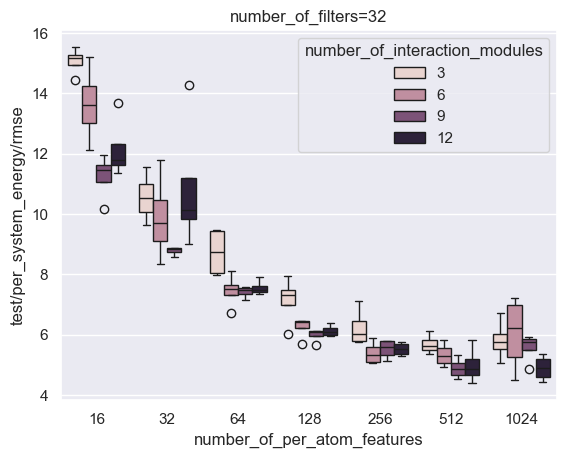

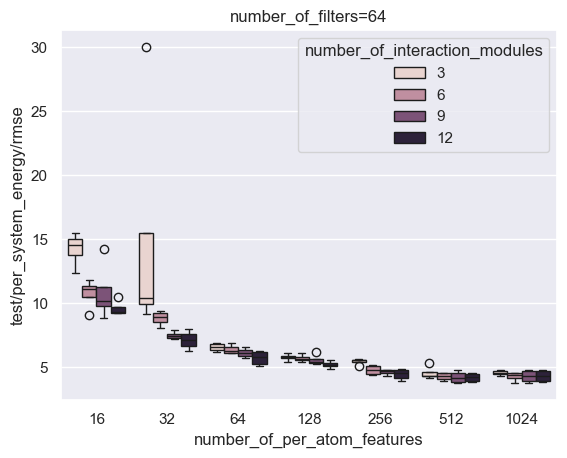

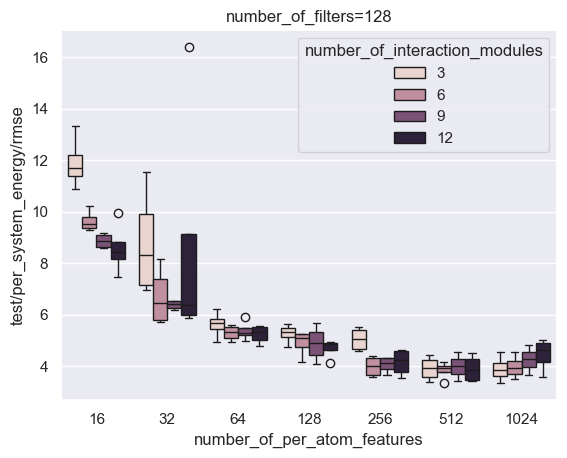

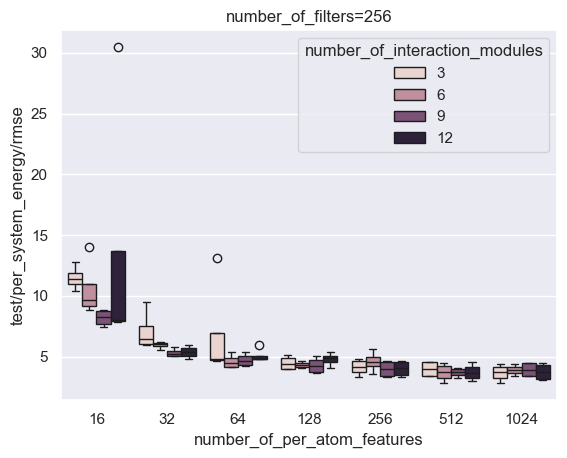

In [209]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

for i in [32, 64, 128, 256]:
    filtered_results = test_results[test_results["seed"] != 43]
    filtered_results = filtered_results[filtered_results["number_of_filters"] == i]
    
    sns.boxplot(
        data=filtered_results,
        x="number_of_per_atom_features",
        y="test/per_system_energy/rmse",
        hue="number_of_interaction_modules",
    ).set_title(f"number_of_filters={i}")
    plt.ylim = (2.5, 20)
    plt.show()

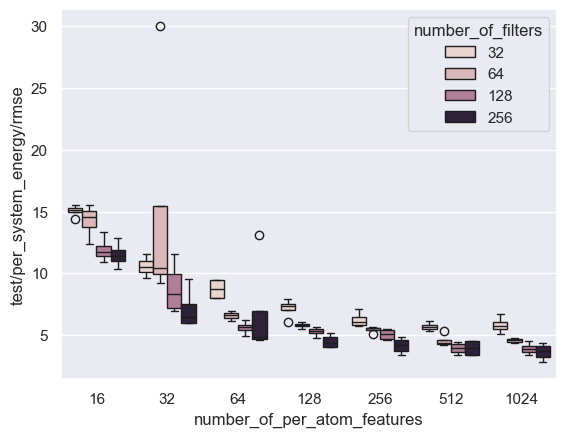

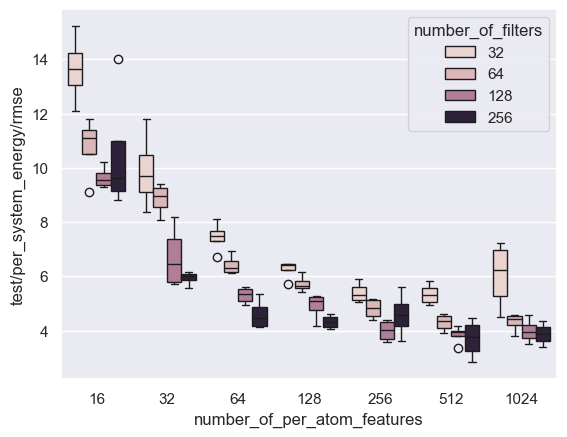

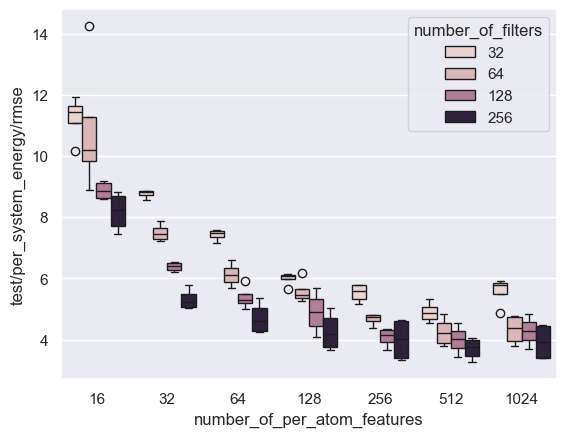

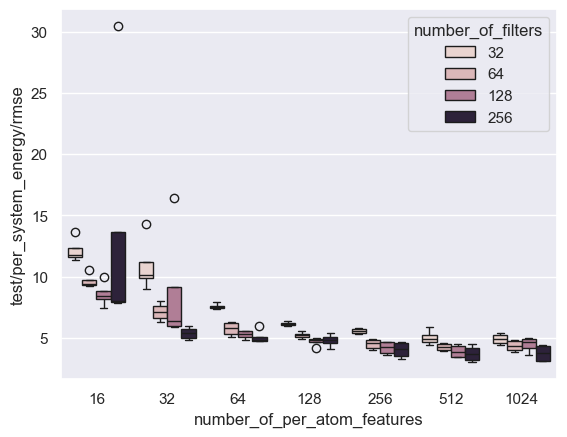

In [199]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

for i in [3, 6, 9, 12]:
    filtered_results = test_results[test_results["seed"] != 43]
    filtered_results = filtered_results[filtered_results["number_of_interaction_modules"] == i]
    
    sns.boxplot(
        data=filtered_results,
        x="number_of_per_atom_features",
        y="test/per_system_energy/rmse",
        hue="number_of_filters"
    )
    plt.ylim=(2.5, 20)
    plt.show()

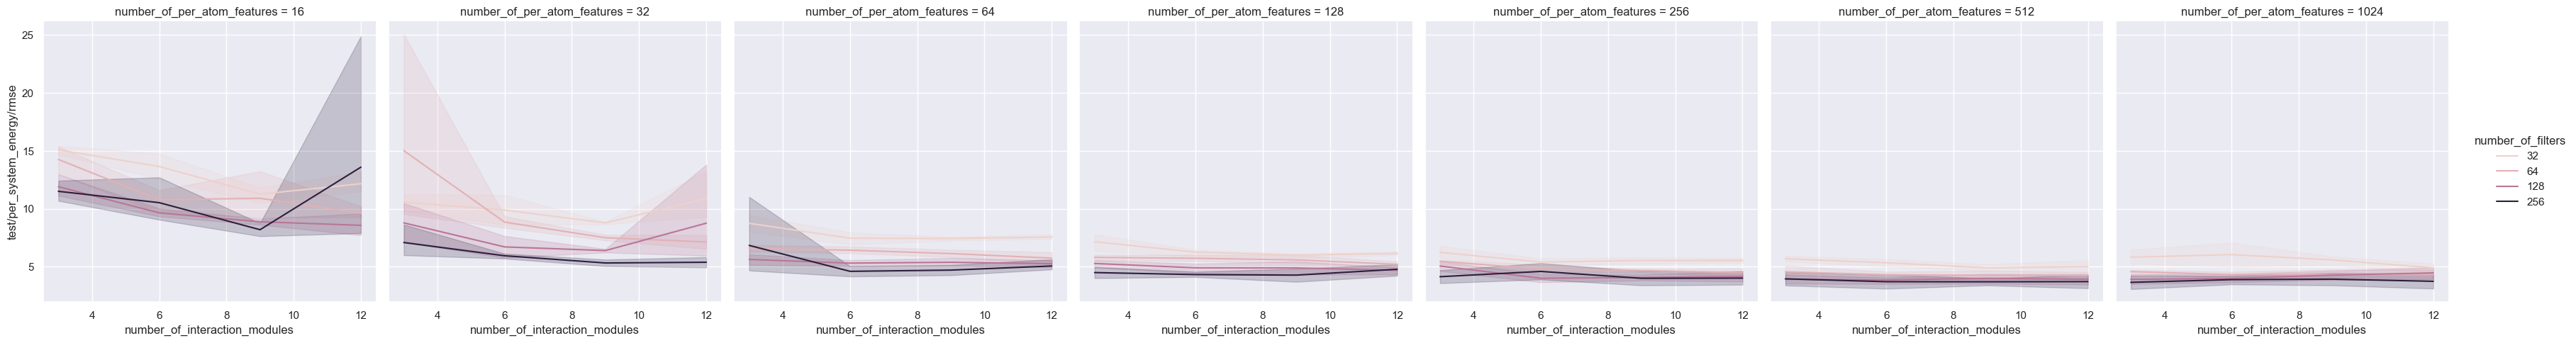

In [143]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

sns.relplot(
    data=filtered_results, kind="line",
    x="number_of_interaction_modules",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
    col="number_of_per_atom_features",
)

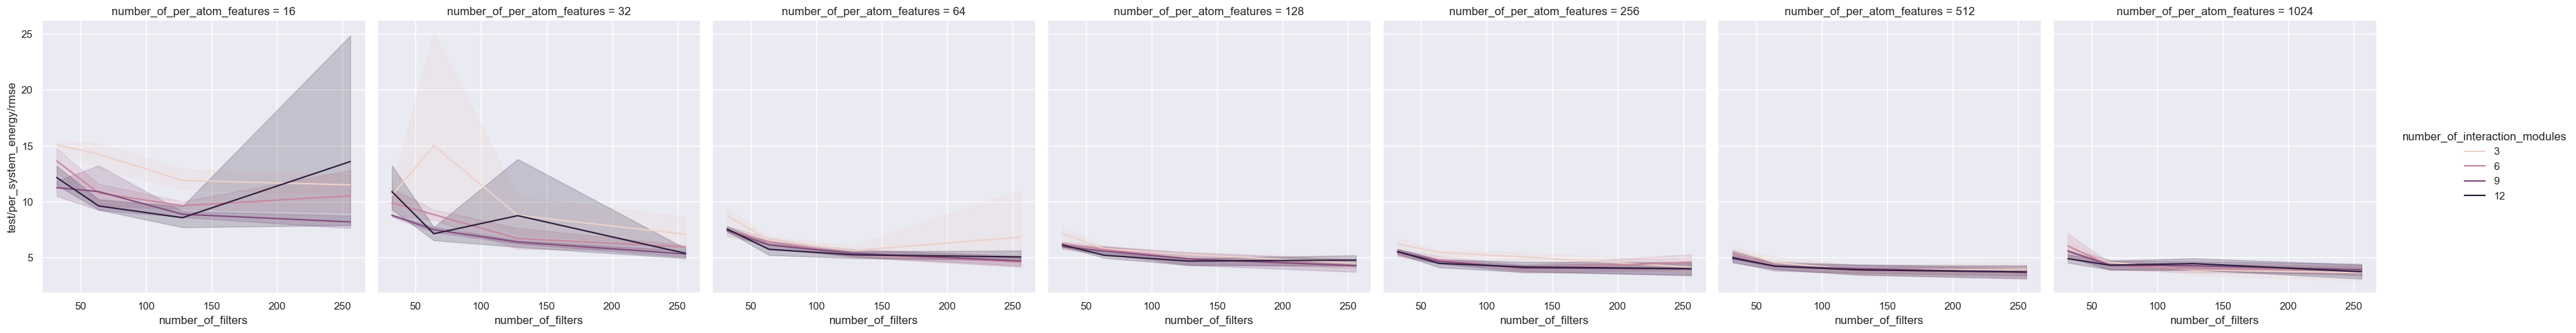

In [101]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

sns.relplot(
    data=filtered_results, kind="line",
    x="number_of_filters",
    y="test/per_system_energy/rmse",
    hue="number_of_interaction_modules",
    col="number_of_per_atom_features",
)

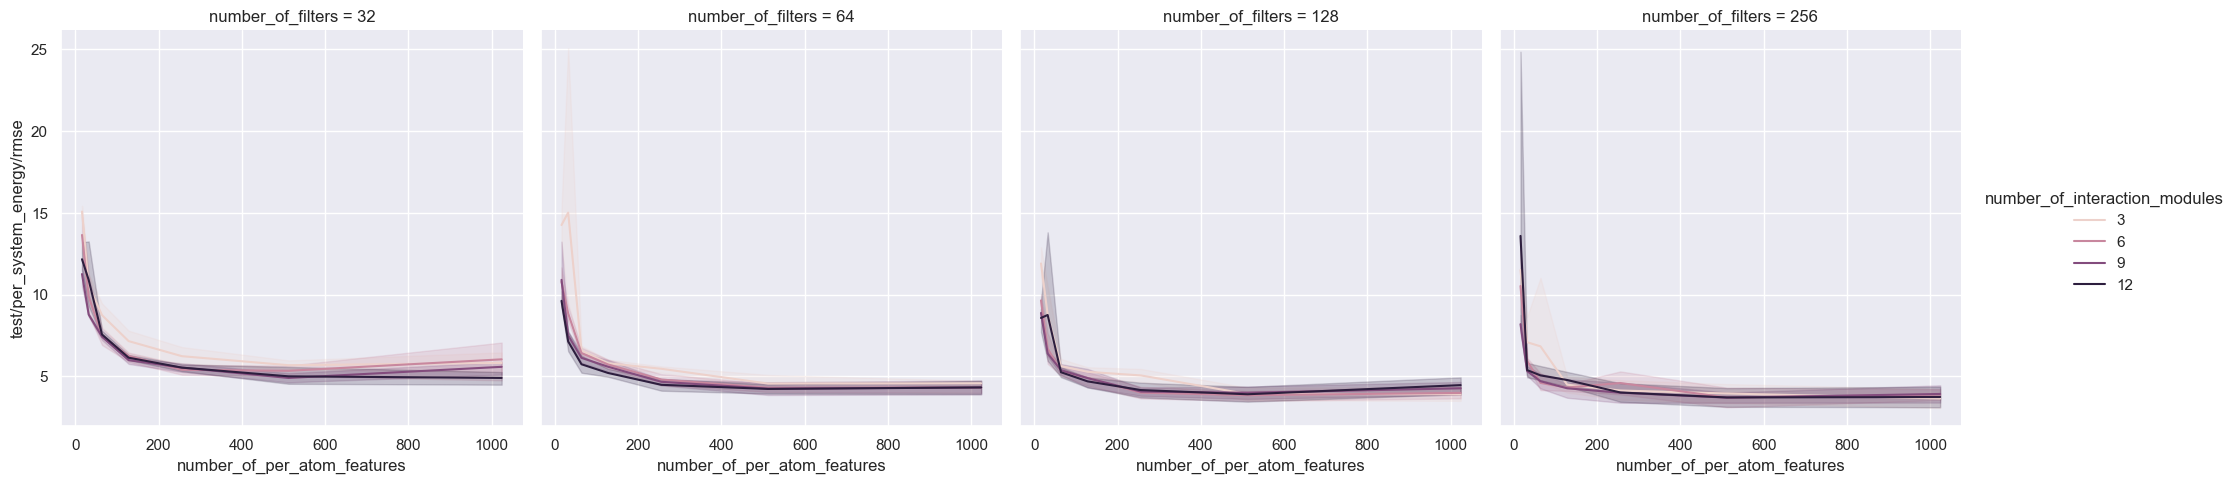

In [102]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

sns.relplot(
    data=filtered_results, kind="line",
    x="number_of_per_atom_features",
    y="test/per_system_energy/rmse",
    hue="number_of_interaction_modules",
    col="number_of_filters",
)

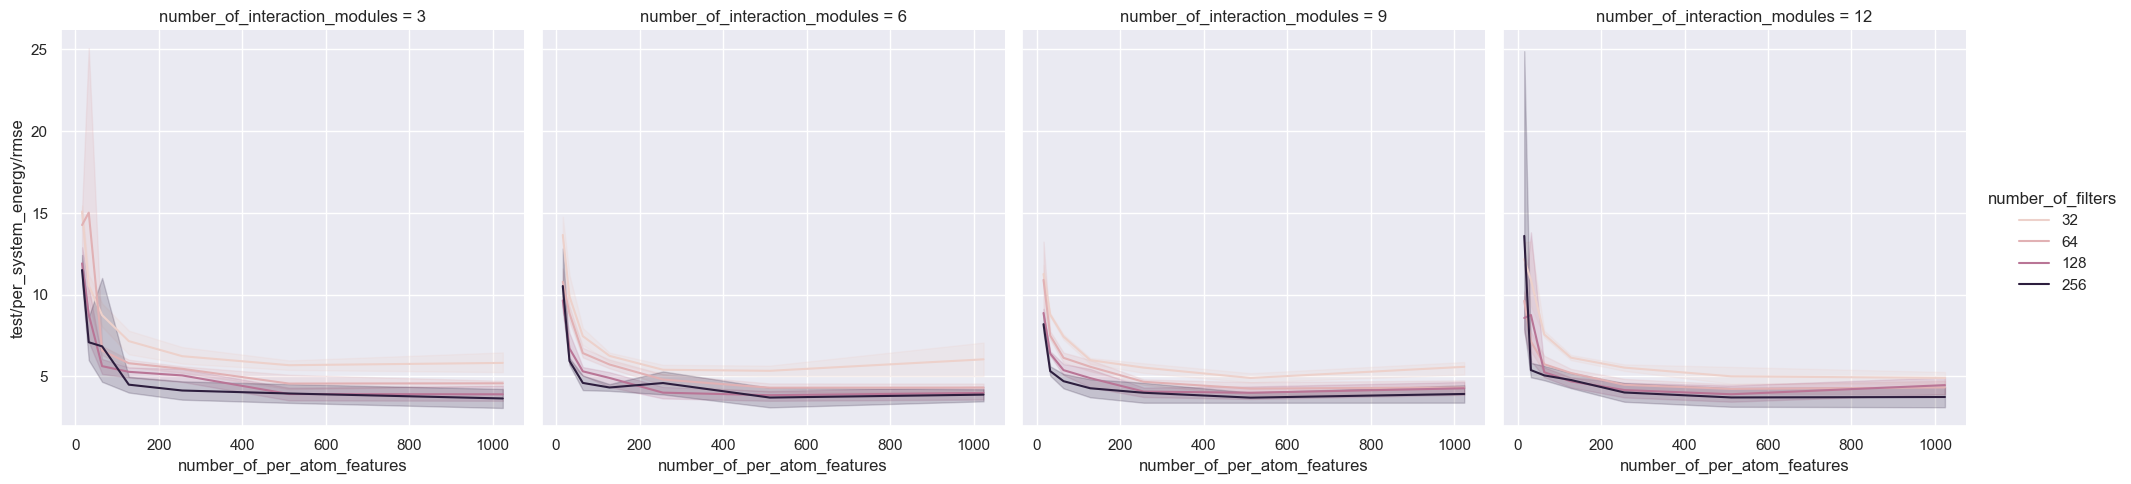

In [103]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]

sns.relplot(
    data=filtered_results, kind="line",
    x="number_of_per_atom_features",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
    col="number_of_interaction_modules",
)

<Axes: xlabel='number_of_interaction_modules', ylabel='test/per_system_energy/rmse'>

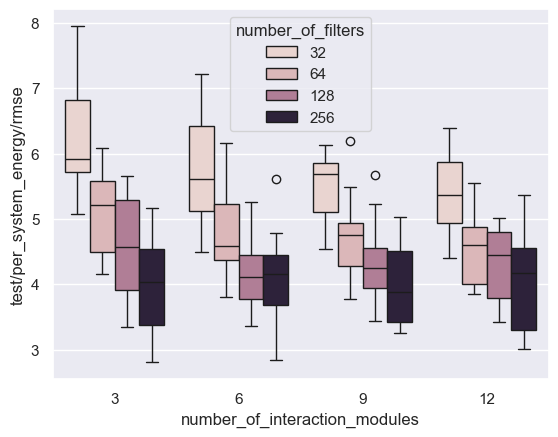

In [191]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]
filtered_results = filtered_results[filtered_results["number_of_per_atom_features"] >= 128]

sns.boxplot(
    data=filtered_results, #kind="line",
    x="number_of_interaction_modules",
    y="test/per_system_energy/rmse",
    hue="number_of_filters",
)

<Axes: xlabel='number_of_filters', ylabel='test/per_system_energy/rmse'>

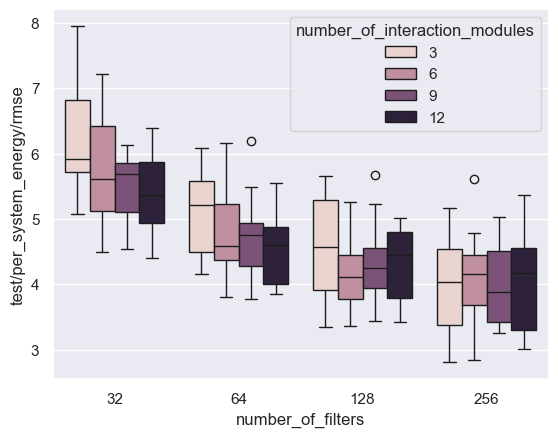

In [192]:
# seed 43 causing large error outliers, ignore for now
filtered_results = test_results[test_results["seed"] != 43]
filtered_results = filtered_results[filtered_results["number_of_per_atom_features"] >= 128]

sns.boxplot(
    data=filtered_results, #kind="line",
    x="number_of_filters",
    y="test/per_system_energy/rmse",
    hue="number_of_interaction_modules",
)